# EDA 아니고 클러스터링

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [146]:
# data dir

data_dir = 'D:/thon/project/tourism/2022년/카드데이터'

# data load

card = pd.read_csv(data_dir + '/card_sports.csv') # load하는데 12초 소요
card = card.drop(['Unnamed: 0', 'gb3', 'v3'], axis = 1) # 스포츠활동 대분류인 gb3 칼럼과, 세부지역인 v3 칼럼은 제거
card['avg_spend'] = round(card['vlm'] / card['usec'], -1).astype(int) # 건당평균소비액 칼럼 생성
card['ta_ym'] = pd.to_datetime(card['ta_ym'], format='%Y%m') # 데이터프레임화
index_to_drop = card.loc[(card['gb2'] == '스포츠용품구매') | (card['gb2'] == '운동경기관람')].index # 스포츠 추천을 위한 클러스터링이므로 용품구매와 관람은 제외
card = card.drop(index_to_drop, axis = 0)


In [147]:
card['gb2'].unique()

array(['레저스포츠', '헬스', '골프', '자전거', '스키'], dtype=object)

In [295]:
group1 = pd.DataFrame(card[['gb2', 'sex_ccd']].value_counts().sort_index()).reset_index()
group1.columns = ['gb2', 'sex_ccd', 'count']
sum_group1 = group1.groupby('gb2').sum().reset_index()
sum_group1.columns = ['gb2', 'total']
group1 = pd.merge(group1, sum_group1, on = 'gb2')
group1['percent'] = round(100 * group1['count'] / group1['total'], 1)
group1 = group1.drop(['count', 'total'], axis = 1)
group1

,gb2,sex_ccd,percent
0,골프,F,33.8
1,골프,M,66.2
2,레저스포츠,F,36.4
3,레저스포츠,M,63.6
4,스키,F,42.8
5,스키,M,57.2
6,자전거,F,37.1
7,자전거,M,62.9
8,헬스,F,38.3
9,헬스,M,61.7


In [296]:
card

,v1,v2,gb2,sex_ccd,cln_age_r,ta_ym,daw_ccd_r,apv_ts_dl_tm_r,vlm,usec,avg_spend
0,세종,세종,레저스포츠,F,20,2021-11-01,WHITE,휴식,2721300,119,22870
1,울산,울산,헬스,M,30,2022-03-01,WHITE,휴식,94882900,588,161370
2,대전,대전,레저스포츠,M,60,2021-11-01,WHITE,활동,798800,57,14010
3,광주,광주,레저스포츠,M,30,2021-09-01,RED,휴식,5021600,193,26020
5,광주,광주,골프,M,40,2021-06-01,WHITE,휴식,25742900,648,39730
...,...,...,...,...,...,...,...,...,...,...,...
7560850,충남,충남,레저스포츠,M,40,2018-12-01,RED,활동,76544759,3873,19760
7560851,충북,충북,골프,M,60,2018-12-01,WHITE,활동,55908953,1237,45200
7560853,경북,강원,레저스포츠,M,20,2018-12-01,RED,활동,65390,10,6540
7560855,경기,경기,골프,F,50,2018-12-01,RED,활동,40990476,487,84170


In [297]:
# 평균소비액의 이상치 판단
q3 = card['avg_spend'].quantile(0.75)
q1 = card['avg_spend'].quantile(0.25)
iqr = q3 - q1
print('Q1-1.5*IQR:', q1 - 1.5 * iqr, 'Q3+1.5*IQR:', q3 + 1.5 * iqr)
card.loc[card['avg_spend'] > q3 + 1.5 * iqr]
df = card.loc[card['avg_spend'] < q3 + 1.5 * iqr] # 이상치 제거한 데이터프레임

index_to_drop = df.loc[df['vlm'] == 0].index # 취급액이 0원인 행도 제거
df = df.drop(index_to_drop, axis = 0)

df.drop(['v2','ta_ym', 'daw_ccd_r', 'apv_ts_dl_tm_r', 'avg_spend'], axis = 1, inplace = True) # 개인특성을 통해 행을 통합하기 위한 칼럼 제거 (거래지역, 거래연월, 평일휴일, 거래시점, 평균취급액)
df.shape

# 나이, 성별, 거주지, 거래지, 종목명 별로 병함
new_df = df.groupby(['v1', 'gb2', 'sex_ccd', 'cln_age_r']).sum()
new_df = new_df.reset_index() # 멀티인덱스 해제
new_df['avg_spend'] = round(new_df['vlm'] / new_df['usec'], -1).astype(int) # 건당 평균취급액 칼럼 추가
new_df

Q1-1.5*IQR: -92760.0 Q3+1.5*IQR: 200360.0


(4882477, 6)

In [375]:
new_df

,v1,gb2,sex_ccd,cln_age_r,vlm,usec,avg_spend,cluster_k3,cluster_k4,cluster_k5,cluster_k10
0,강원,골프,F,20,2553543331,54524,46830,1,0,2,3
1,강원,골프,F,30,6468880032,101988,63430,0,3,0,6
2,강원,골프,F,40,21507390564,267518,80400,0,3,0,1
3,강원,골프,F,50,24260970138,284697,85220,0,3,0,1
4,강원,골프,F,60,9164414433,110799,82710,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
845,충북,헬스,M,20,20629606492,243993,84550,0,3,0,1
846,충북,헬스,M,30,20444792413,268358,76180,0,3,0,6
847,충북,헬스,M,40,25270146988,330424,76480,0,3,0,6
848,충북,헬스,M,50,18036290533,216804,83190,0,3,0,1


In [376]:
new_df.drop(['cluster_k3', 'cluster_k4', 'cluster_k5', 'cluster_k10'], axis = 1)

,v1,gb2,sex_ccd,cln_age_r,vlm,usec,avg_spend
0,강원,골프,F,20,2553543331,54524,46830
1,강원,골프,F,30,6468880032,101988,63430
2,강원,골프,F,40,21507390564,267518,80400
3,강원,골프,F,50,24260970138,284697,85220
4,강원,골프,F,60,9164414433,110799,82710
...,...,...,...,...,...,...,...
845,충북,헬스,M,20,20629606492,243993,84550
846,충북,헬스,M,30,20444792413,268358,76180
847,충북,헬스,M,40,25270146988,330424,76480
848,충북,헬스,M,50,18036290533,216804,83190


<function matplotlib.pyplot.show(close=None, block=None)>

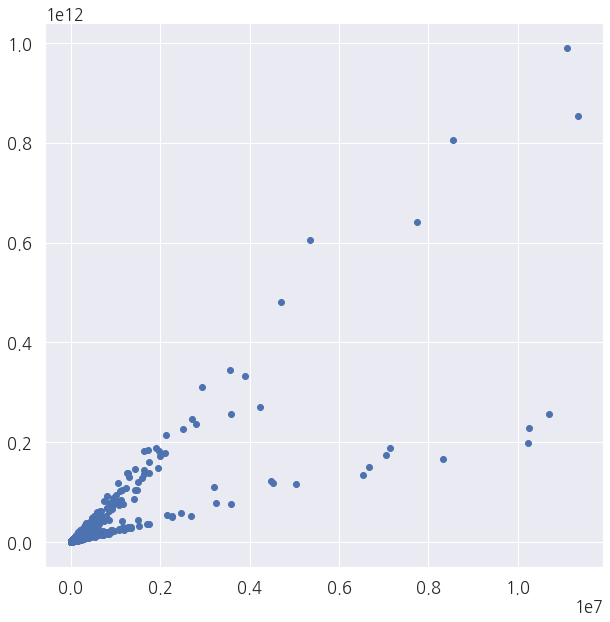

In [298]:
# 새로운 데이터프레임 시각화
plt.figure(figsize = (10, 10))
plt.scatter(new_df['usec'], new_df['vlm'])
plt.show

In [224]:
# new_df 표쥰화
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_count = new_df[['vlm', 'usec', 'avg_spend']]

sc = StandardScaler()
sc_scaled = sc.fit_transform(df_count)
pd.DataFrame(sc_scaled)

,0,1,2
0,-0.300004,-0.322919,-0.558610
1,-0.247229,-0.283440,0.123032
2,-0.044524,-0.145759,0.819866
3,-0.007409,-0.131470,1.017789
4,-0.210896,-0.276111,0.914721
...,...,...,...
845,-0.056356,-0.165326,0.990277
846,-0.058847,-0.145060,0.646581
847,0.006194,-0.093436,0.658900
848,-0.091312,-0.187941,0.934431


In [225]:
# K-Means 클러스터링 (k = 3)
k = 3

model = KMeans(n_clusters = k, random_state = 11)
model.fit(sc_scaled)
new_df['cluster_k3'] = model.fit_predict(sc_scaled)

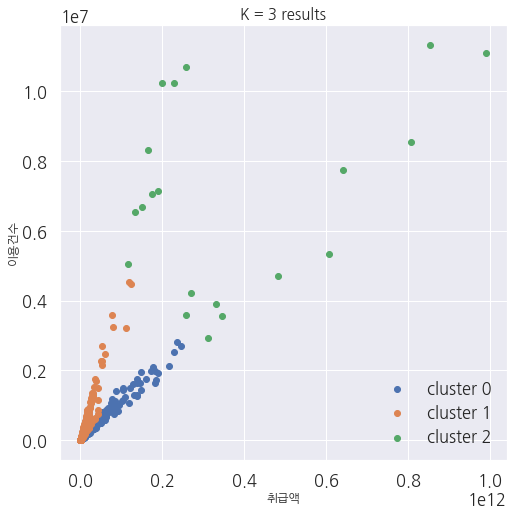

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(new_df.loc[new_df['cluster_k3'] == i, 'vlm'], new_df.loc[new_df['cluster_k3'] == i, 'usec'],
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('취급액', size = 12)
plt.ylabel('이용건수', size = 12)
plt.show()

In [231]:
new_df['cluster_k3'].value_counts().sort_index()

0    449
1    381
2     20
Name: cluster_k3, dtype: int64

In [228]:
# K-Means 클러스터링 (k = 4)
k = 4

model = KMeans(n_clusters = k, random_state = 11)
model.fit(sc_scaled)
new_df['cluster_k4'] = model.fit_predict(sc_scaled)

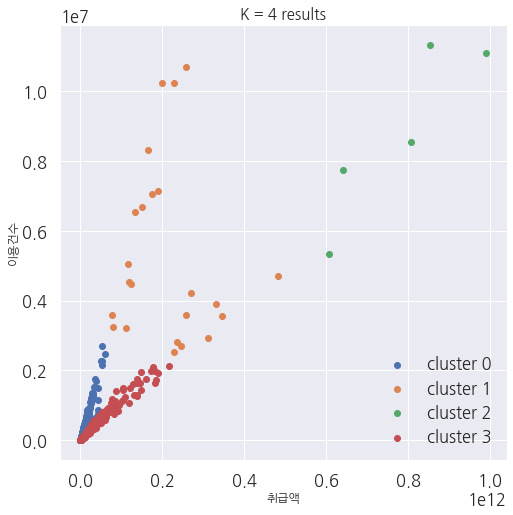

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(new_df.loc[new_df['cluster_k4'] == i, 'vlm'], new_df.loc[new_df['cluster_k4'] == i, 'usec'],
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('취급액', size = 12)
plt.ylabel('이용건수', size = 12)
plt.show()

In [230]:
new_df['cluster_k4'].value_counts().sort_index()

0    377
1     23
2      5
3    445
Name: cluster_k4, dtype: int64

In [232]:
# K-Means 클러스터링 (k = 5)
k = 5

model = KMeans(n_clusters = k, random_state = 11)
model.fit(sc_scaled)
new_df['cluster_k5'] = model.fit_predict(sc_scaled)

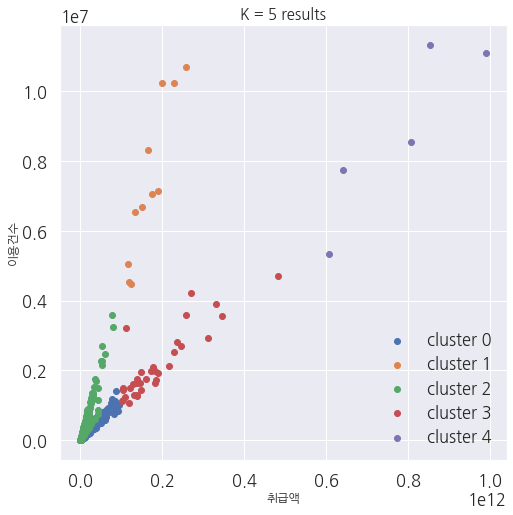

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(new_df.loc[new_df['cluster_k5'] == i, 'vlm'], new_df.loc[new_df['cluster_k5'] == i, 'usec'],
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('취급액', size = 12)
plt.ylabel('이용건수', size = 12)
plt.show()

In [234]:
new_df['cluster_k5'].value_counts().sort_index()

0    446
1     11
2    354
3     34
4      5
Name: cluster_k5, dtype: int64

c:\Users\sujin\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Computing time:  0.65305495262146


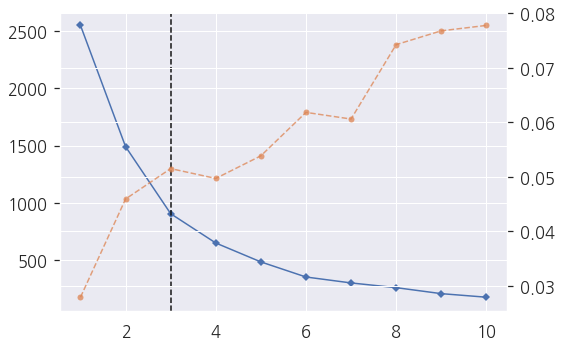

In [235]:
from yellowbrick.cluster import KElbowVisualizer
import time

model = KMeans()
visualizer = KElbowVisualizer(model, k = (1,11))
start_time = time.time()
visualizer.fit(sc_scaled)
end_time = time.time()
print('Computing time: ', end_time - start_time)

## 로지스틱 회귀분석

In [359]:
# 평균소비액의 이상치 판단
q3 = card['avg_spend'].quantile(0.75)
q1 = card['avg_spend'].quantile(0.25)
iqr = q3 - q1
print('Q1-1.5*IQR:', q1 - 1.5 * iqr, 'Q3+1.5*IQR:', q3 + 1.5 * iqr)
card.loc[card['avg_spend'] > q3 + 1.5 * iqr]
df2 = card.loc[card['avg_spend'] < q3 + 1.5 * iqr] # 이상치 제거한 데이터프레임

index_to_drop = df2.loc[df2['vlm'] == 0].index # 취급액이 0원인 행도 제거
df2 = df2.drop(index_to_drop, axis = 0)

df2.drop(['v2','ta_ym', 'avg_spend'], axis = 1, inplace = True) # 행을 통합하기 위한 칼럼 제거 (거래지역, 거래연월, 평균취급액)
df2.shape

# 칼럼별로 병함
new_df2 = df2.groupby(['v1', 'gb2', 'sex_ccd', 'cln_age_r', 'daw_ccd_r', 'apv_ts_dl_tm_r']).sum()
new_df2 = new_df2.reset_index() # 멀티인덱스 해제
new_df2['cln_age_r'] = new_df2['cln_age_r'].astype(str) # 나이변수 범주화
new_df2['avg_spend'] = round(new_df2['vlm'] / new_df2['usec'], -1).astype(int) # 건당 평균취급액 칼럼 추가
new_df2

Q1-1.5*IQR: -92760.0 Q3+1.5*IQR: 200360.0


,v1,gb2,sex_ccd,cln_age_r,daw_ccd_r,apv_ts_dl_tm_r,vlm,usec,avg_spend
0,강원,골프,F,20,RED,취침,18228897,338,53930
1,강원,골프,F,20,RED,활동,429785801,12464,34480
2,강원,골프,F,20,RED,휴식,175375899,4643,37770
3,강원,골프,F,20,WHITE,취침,61856329,913,67750
4,강원,골프,F,20,WHITE,활동,1397332871,25580,54630
...,...,...,...,...,...,...,...,...,...
4735,충북,헬스,M,60,RED,활동,740826585,11876,62380
4736,충북,헬스,M,60,RED,휴식,94421465,2141,44100
4737,충북,헬스,M,60,WHITE,취침,62806128,1843,34080
4738,충북,헬스,M,60,WHITE,활동,2978082824,32648,91220


In [365]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

new_df2['target'] = 0
new_df2.loc[new_df2['gb2'] == '골프', 'target'] = 1
train, test = train_test_split(new_df2, test_size = 0.3, random_state = 0, stratify = new_df2['target'])
train_X = train.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
train_y = train['target']
test_X = test.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
test_y = test['target']
X = new_df2.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
y = new_df2['target']

train_X_dummy = pd.get_dummies(train_X, drop_first = True)
test_X_dummy = pd.get_dummies(test_X, drop_first = True)

Accuracy for Random Forests is 0.7721518987341772


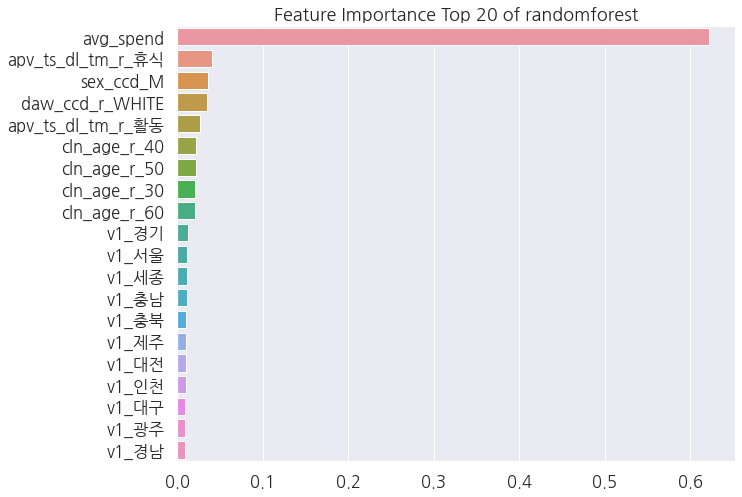

In [366]:
# RandomForest의 Top 20 feature

model = RandomForestClassifier()
model.fit(train_X_dummy, train_y)
prediction_rf = model.predict(test_X_dummy)
print('Accuracy for Random Forests is', metrics.accuracy_score(prediction_rf, test_y))
ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X_dummy.columns)
ft_top20 = ft_series.sort_values(ascending = False)[:20]
#ft_top20.index = ['여성', '남성', '가구소득 3-400만원', '경기', '서울', '가구소득 4-500만원', '50대', '가구소득 2-300만원', '초졸 이하', '가구소득 600만원 이상', '70세 이상', '가구소득 5-600만원', '대졸 이상', '고졸', '40대', '주간 경제활동 O', '주간 경제활동 X', '동거가구원수 2인', '부산', '경남']

plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 20 of randomforest')
sns.barplot(x = ft_top20, y = ft_top20.index)
plt.show()

In [371]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

new_df2['target'] = 0
new_df2.loc[new_df2['gb2'] == '레저스포츠', 'target'] = 1
train, test = train_test_split(new_df2, test_size = 0.3, random_state = 0, stratify = new_df2['target'])
train_X = train.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
train_y = train['target']
test_X = test.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
test_y = test['target']
X = new_df2.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
y = new_df2['target']

train_X_dummy = pd.get_dummies(train_X, drop_first = True)
test_X_dummy = pd.get_dummies(test_X, drop_first = True)

Accuracy for Random Forests is 0.8663853727144867


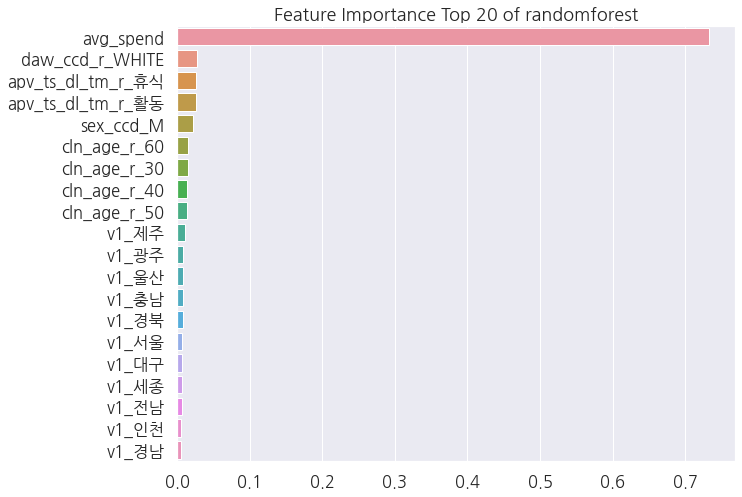

In [372]:
# RandomForest의 Top 20 feature

model = RandomForestClassifier()
model.fit(train_X_dummy, train_y)
prediction_rf = model.predict(test_X_dummy)
print('Accuracy for Random Forests is', metrics.accuracy_score(prediction_rf, test_y))
ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X_dummy.columns)
ft_top20 = ft_series.sort_values(ascending = False)[:20]
#ft_top20.index = ['여성', '남성', '가구소득 3-400만원', '경기', '서울', '가구소득 4-500만원', '50대', '가구소득 2-300만원', '초졸 이하', '가구소득 600만원 이상', '70세 이상', '가구소득 5-600만원', '대졸 이상', '고졸', '40대', '주간 경제활동 O', '주간 경제활동 X', '동거가구원수 2인', '부산', '경남']

plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 20 of randomforest')
sns.barplot(x = ft_top20, y = ft_top20.index)
plt.show()

In [377]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

new_df2['target'] = 0
new_df2.loc[new_df2['gb2'] == '자전거', 'target'] = 1
train, test = train_test_split(new_df2, test_size = 0.3, random_state = 0, stratify = new_df2['target'])
train_X = train.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
train_y = train['target']
test_X = test.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
test_y = test['target']
X = new_df2.drop(['gb2', 'vlm', 'usec', 'target'], axis = 1)
y = new_df2['target']

train_X_dummy = pd.get_dummies(train_X, drop_first = True)
test_X_dummy = pd.get_dummies(test_X, drop_first = True)

Accuracy for Random Forests is 0.7749648382559775


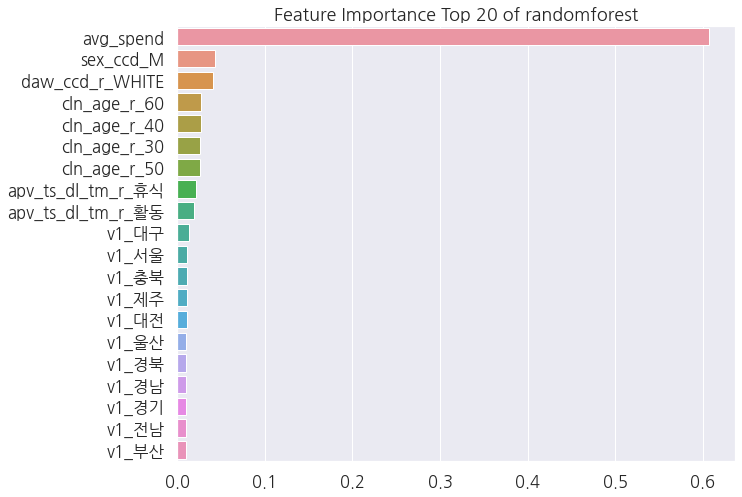

In [378]:
# RandomForest의 Top 20 feature

model = RandomForestClassifier()
model.fit(train_X_dummy, train_y)
prediction_rf = model.predict(test_X_dummy)
print('Accuracy for Random Forests is', metrics.accuracy_score(prediction_rf, test_y))
ft_importance_value = model.feature_importances_
ft_series = pd.Series(ft_importance_value, index = train_X_dummy.columns)
ft_top20 = ft_series.sort_values(ascending = False)[:20]
#ft_top20.index = ['여성', '남성', '가구소득 3-400만원', '경기', '서울', '가구소득 4-500만원', '50대', '가구소득 2-300만원', '초졸 이하', '가구소득 600만원 이상', '70세 이상', '가구소득 5-600만원', '대졸 이상', '고졸', '40대', '주간 경제활동 O', '주간 경제활동 X', '동거가구원수 2인', '부산', '경남']

plt.figure(figsize = (10, 8))
plt.title('Feature Importance Top 20 of randomforest')
sns.barplot(x = ft_top20, y = ft_top20.index)
plt.show()

## PCA

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df2 = card[['vlm', 'usec', 'avg_spend']]

sc = StandardScaler()
card_scaled_2 = sc.fit_transform(df2)

In [16]:
# K-Means 클러스터링 (k = 3)
k = 3

model = KMeans(n_clusters = k, random_state = 11)
model.fit(card_scaled_2)
card['cluster_df2_k3'] = model.fit_predict(card_scaled_2)

In [17]:
from sklearn.decomposition import PCA
X = card_scaled_2.copy()

pca = PCA(n_components = 2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster_k3'] = card['cluster_df2_k3']

In [25]:
pca_df.loc[pca_df[0] == pca_df[0].max()]

,0,1,cluster_k3
4176481,443.902585,1964.949717,0.0


In [31]:
pca_df = pca_df.drop([4176481])
pca_df.shape

(7560855, 3)

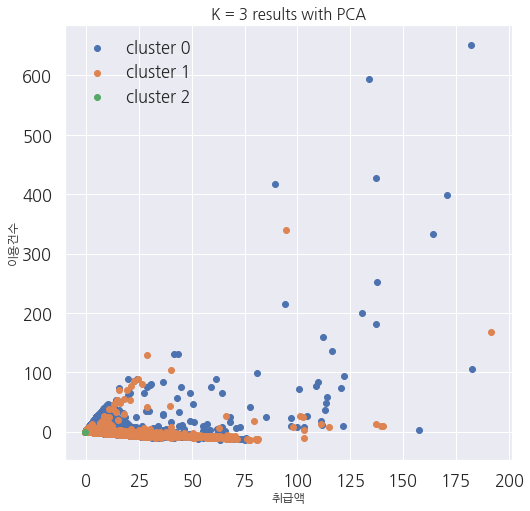

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(pca_df.loc[pca_df['cluster_k3'] == i, 0], pca_df.loc[pca_df['cluster_k3'] == i, 1],
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results with PCA'%k , size = 15)
plt.xlabel('취급액', size = 12)
plt.ylabel('이용건수', size = 12)
plt.show()

In [46]:
pca_df.loc[pca_df['cluster_k3'] == 2]

,0,1,cluster_k3
4176484,-0.349286,-0.112521,2.0


In [48]:
card.loc[card['avg_spend'] == card['avg_spend'].max()]

,v1,v2,v3,gb3,gb2,sex_ccd,cln_age_r,ta_ym,daw_ccd_r,apv_ts_dl_tm_r,vlm,usec,cluster_k3,cluster_k4,cluster_k5,avg_spend,cluster_df2_k3,cluster_df2_k4
4176484,부산,부산,강서구,스포츠활동,골프,M,20,2019-02-01,RED,활동,5029999994,5,2,1,4,1.006000e+09,2,2


In [34]:
pca_df.groupby('cluster_k3').count()

,0,1
cluster_k3,,
0.0,7460083,7460083
1.0,100768,100768
2.0,1,1


In [50]:
# 이상치 행 제거하고 해볼까
card_remove_outlier = card.drop([4176481, 4176484])
card_remove_outlier.shape

(7560854, 18)

In [57]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df2 = card_remove_outlier[['vlm', 'usec', 'avg_spend']]

sc = StandardScaler()
card_scaled_2 = sc.fit_transform(df2)

In [60]:
# K-Means 클러스터링 (k = 3)
k = 3

model = KMeans(n_clusters = k, random_state = 11)
model.fit(card_scaled_2)
card_remove_outlier['cluster_df2_k3'] = model.fit_predict(card_scaled_2)

In [61]:
from sklearn.decomposition import PCA
X = card_scaled_2.copy()

pca = PCA(n_components = 2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster_k3'] = card_remove_outlier['cluster_df2_k3']

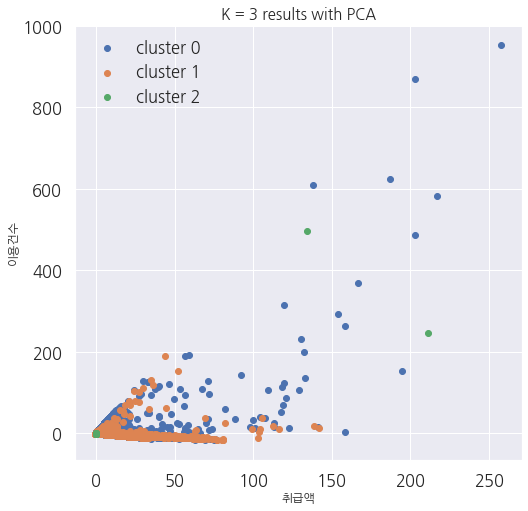

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(pca_df.loc[pca_df['cluster_k3'] == i, 0], pca_df.loc[pca_df['cluster_k3'] == i, 1],
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results with PCA'%k , size = 15)
plt.xlabel('취급액', size = 12)
plt.ylabel('이용건수', size = 12)
plt.show()

In [63]:
pca_df.groupby('cluster_k3').count()

,0,1
cluster_k3,,
0.0,7459442,7459442
1.0,101395,101395
2.0,12,12


In [35]:
# K-Means 클러스터링 (k = 3)
k = 4

model = KMeans(n_clusters = k, random_state = 11)
model.fit(card_scaled_2)
card['cluster_df2_k4'] = model.fit_predict(card_scaled_2)

In [36]:
from sklearn.decomposition import PCA
X = card_scaled_2.copy()

pca = PCA(n_components = 2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df2 = pd.DataFrame(x_pca)
pca_df2['cluster_k4'] = card['cluster_df2_k4']

In [41]:
pca_df2.groupby('cluster_k4').count()

,0,1
cluster_k4,,
0.0,7308490,7308490
1.0,24051,24051
2.0,1,1
3.0,228311,228311


In [43]:
pca_df2.loc[pca_df2['cluster_k4'] == 2]

,0,1,cluster_k4
4176484,-0.349286,-0.112521,2.0


In [45]:
card.loc[4176484]

v1                                 부산
v2                                 부산
v3                                강서구
gb3                             스포츠활동
gb2                                골프
sex_ccd                             M
cln_age_r                          20
ta_ym             2019-02-01 00:00:00
daw_ccd_r                         RED
apv_ts_dl_tm_r                     활동
vlm                        5029999994
usec                                5
cluster_k3                          2
cluster_k4                          1
cluster_k5                          4
avg_spend                1005999999.0
cluster_df2_k3                      2
cluster_df2_k4                      2
Name: 4176484, dtype: object

In [40]:
pca_df2.loc[pca_df2[0] == pca_df2[0].max()]

,0,1,cluster_k4
4176481,443.902585,1964.949717,0.0


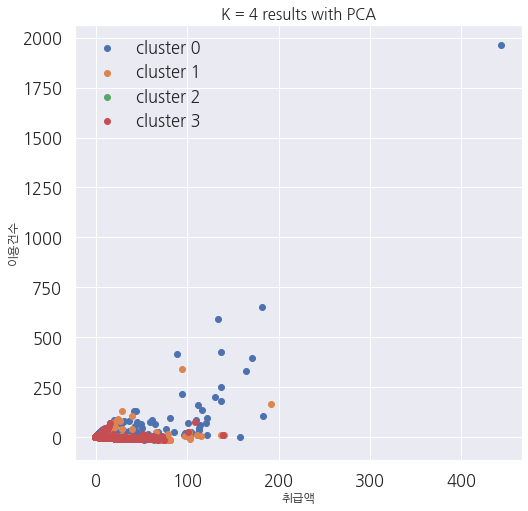

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
plt.rc("font", family = "NanumGothic") # 한글깨짐 방지
plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(pca_df2.loc[pca_df2['cluster_k4'] == i, 0], pca_df2.loc[pca_df2['cluster_k4'] == i, 1],
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results with PCA'%k , size = 15)
plt.xlabel('취급액', size = 12)
plt.ylabel('이용건수', size = 12)
plt.show()

## 추천시스템화

In [416]:
from surprise import SVD, accuracy # SVD model, 평가
from surprise import Reader, Dataset # SVD model의 dataset

In [417]:
# 평균소비액의 이상치 판단
q3 = card['avg_spend'].quantile(0.75)
q1 = card['avg_spend'].quantile(0.25)
iqr = q3 - q1
card.loc[card['avg_spend'] > q3 + 1.5 * iqr]
df = card.loc[card['avg_spend'] < q3 + 1.5 * iqr] # 이상치 제거한 데이터프레임

index_to_drop = df.loc[df['vlm'] == 0].index # 취급액이 0원인 행도 제거
df = df.drop(index_to_drop, axis = 0)

df.drop(['v2','ta_ym', 'daw_ccd_r', 'apv_ts_dl_tm_r', 'avg_spend'], axis = 1, inplace = True) # 개인특성을 통해 행을 통합하기 위한 칼럼 제거 (거래지역, 거래연월, 평일휴일, 거래시점, 평균취급액)
df.shape

# 나이, 성별, 거주지, 거래지, 종목명 별로 병함
new_df = df.groupby(['v1', 'sex_ccd', 'cln_age_r', 'gb2']).sum()
new_df = new_df.reset_index() # 멀티인덱스 해제
new_df['avg_spend'] = round(new_df['vlm'] / new_df['usec'], -1).astype(int) # 건당 평균취급액 칼럼 추가
new_df['cln_age_r'] = new_df['cln_age_r'].astype(str)
new_df['as_person'] = new_df['v1'] + new_df['sex_ccd'] + new_df['cln_age_r']
new_df.drop(['vlm', 'usec'], axis = 1, inplace = True)

# new_df['avg_spend'] 10개 구간으로 나눠서 레이팅 지표로 삼기
range = new_df['avg_spend'].max() - new_df['avg_spend'].min()
rating_cluster_num = 5
bins = pd.cut(new_df['avg_spend'], rating_cluster_num, labels = ['1', '2', '3', '4', '5'])
new_df['rating'] = bins
new_df

,v1,sex_ccd,cln_age_r,gb2,avg_spend,as_person,rating
0,강원,F,20,골프,46830,강원F20,2
1,강원,F,20,레저스포츠,21110,강원F20,1
2,강원,F,20,스키,40770,강원F20,2
3,강원,F,20,자전거,34880,강원F20,1
4,강원,F,20,헬스,87340,강원F20,4
...,...,...,...,...,...,...,...
845,충북,M,60,골프,91310,충북M60,4
846,충북,M,60,레저스포츠,18390,충북M60,1
847,충북,M,60,스키,40150,충북M60,2
848,충북,M,60,자전거,87990,충북M60,4


In [439]:
new_df['rating'].value_counts().sort_index()

1    198
2    164
3    228
4    206
5     54
Name: rating, dtype: int64

In [431]:
# 추천 시스템에 사용할 데이터프레임 생성
recommend_df = new_df[['as_person', 'gb2', 'rating']]
recommend_df['rating'].astype(int)
num_test = int(recommend_df.shape[0] / 5 * 0.3)
num_train = int(recommend_df.shape[0] / 5 - num_test)
num_train_row = num_train * 5
train = recommend_df[:num_train_row]
test = recommend_df[num_train_row:]
print(train.shape, test.shape)

(595, 3) (255, 3)


In [442]:
# 추천 시스템 패키지에 맞는 데이터프레임 생성 (Surprise에서 제시한 데이터 구조를 따라야함)
recommend_df = new_df[['as_person', 'gb2', 'rating']]
recommend_df.columns = ['userId', 'sportsId', 'rating']
recommend_df['rating'].astype(int)
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(recommend_df[['userId', 'sportsId', 'rating']], reader = reader)

In [445]:
# GridSearch로 최적의 파라미터 찾기
from surprise.model_selection import GridSearchCV, cross_validate

param_grid = {'n_factors': [25, 50, 75,  100], 'lr_all': [0.5, 0.05], 'reg_all': [0.06, 0.04]}
gs = GridSearchCV(algo_class = SVD, measures = ['RMSE'], param_grid = param_grid)
gs.fit(data)

print('Best Score: ', gs.best_score['rmse'])
print('Best Parameters: ', gs.best_params['rmse'])

Best Score:  0.7724207413300206
Best Parameters:  {'n_factors': 100, 'lr_all': 0.05, 'reg_all': 0.04}


In [470]:
# 최적의 파라미터로 predict
from surprise import accuracy
from surprise.model_selection import train_test_split

model = SVD(n_factors = 100, lr_all = 0.05, reg_all = 0.04)
trainset, testset = train_test_split(data, test_size=.25)
model.fit(trainset)
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.7992


0.7992487102467519

In [471]:
train

,as_person,gb2,rating
461,세종F40,레저스포츠,1
40,강원M50,골프,4
474,세종F60,헬스,2
113,경남F40,자전거,4
543,울산M50,자전거,4
...,...,...,...
241,광주M50,레저스포츠,1
253,대구F20,자전거,1
390,부산M50,골프,4
667,전북F50,스키,2


In [476]:
test_id = '서울M20'
sports_category = ['레저스포츠', '골프', '자전거', '헬스']
for sports_cat in sports_category:
    print(model.predict(test_id, sports_cat))

recommend_df.loc[recommend_df['userId'] == '서울M20']

user: 서울M20      item: 레저스포츠      r_ui = None   est = 1.00   {'was_impossible': False}
user: 서울M20      item: 골프         r_ui = None   est = 2.24   {'was_impossible': False}
user: 서울M20      item: 자전거        r_ui = None   est = 1.99   {'was_impossible': False}
user: 서울M20      item: 헬스         r_ui = None   est = 4.76   {'was_impossible': False}


,userId,sportsId,rating
425,서울M20,골프,2
426,서울M20,레저스포츠,1
427,서울M20,스키,2
428,서울M20,자전거,2
429,서울M20,헬스,5
